In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!pip install tensorflow-gpu==2.8.3
#!pip install tf-models-official==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 497.9 MB 34 kB/s 
     |████████████████████████████████| 5.8 MB 52.3 MB/s 
     |████████████████████████████████| 1.4 MB 52.5 MB/s 
     |████████████████████████████████| 462 kB 73.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import math
import matplotlib.pyplot as plt
#import tensorflow_models as tfm

In [3]:
tf.print(tf.__version__) # Needs to be 2.8.3 or it will take eons to run

2.8.3


In [4]:
# Takes 1.0, 0.75, 0.5, 0.25, 0.1
unsupervised_scale = 1
# Takes 1.0, 0.1, 0.01
supervised_scale = 1

uns_train_batch_size = int(400 * unsupervised_scale)
uns_val_batch_size = int(100 * unsupervised_scale)
sup_train_batch_size = max(int(uns_train_batch_size * supervised_scale), int(uns_train_batch_size / 10))
sup_val_batch_size = max(int(uns_val_batch_size * supervised_scale), int(uns_val_batch_size / 10))

In [5]:
# Load dataset
train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True, shuffle_files=True)
val_ds = train_ds.take(10000)
train_ds = train_ds.skip(10000)

# Adjust images in supervised and unsupervised portions based off assigned scale
uns_val_ds = val_ds.take(int(len(val_ds) * unsupervised_scale))
uns_train_ds = train_ds.take(int(len(train_ds) * unsupervised_scale))
sup_val_ds = uns_val_ds.take(int(len(uns_val_ds) * supervised_scale))
sup_train_ds = uns_train_ds.take(int(len(uns_train_ds) * supervised_scale))

# Set up batches and prefetching for datasets
uns_train_ds = uns_train_ds.shuffle(buffer_size=10*uns_train_batch_size).batch(uns_train_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
uns_val_ds = uns_val_ds.batch(uns_val_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
sup_train_ds = sup_train_ds.shuffle(buffer_size=10*sup_train_batch_size).batch(sup_train_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
sup_val_ds = sup_val_ds.batch(sup_val_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(100).prefetch(buffer_size=tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteZ3A2ES/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteZ3A2ES/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Causes jitter in images
class RandomJitter(layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, images):
        img_count = tf.shape(images)[0]
        brightness= 1 + tf.random.uniform((img_count, 1, 1, 1), minval=-0.6, maxval=0.6)
        jitter = tf.random.uniform((img_count, 1, 3, 3), minval=-0.2, maxval=0.2)
        final_jitter = (tf.eye(3, batch_shape=[img_count, 1]) * brightness + jitter)
        images = tf.clip_by_value(tf.matmul(images, final_jitter), 0, 1)
        return images


# Image augmentation pipeline for images in SimCLR
def get_augmenter():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1 / 255)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomTranslation(0.25, 0.25)(x)
    x = layers.RandomZoom((-0.5, 0.0), (-0.5, 0.0))(x)
    outputs = RandomJitter()(x)
    return tf.keras.Model(inputs, outputs)

Text(0.5, 0.6, 'Augmented Images:')

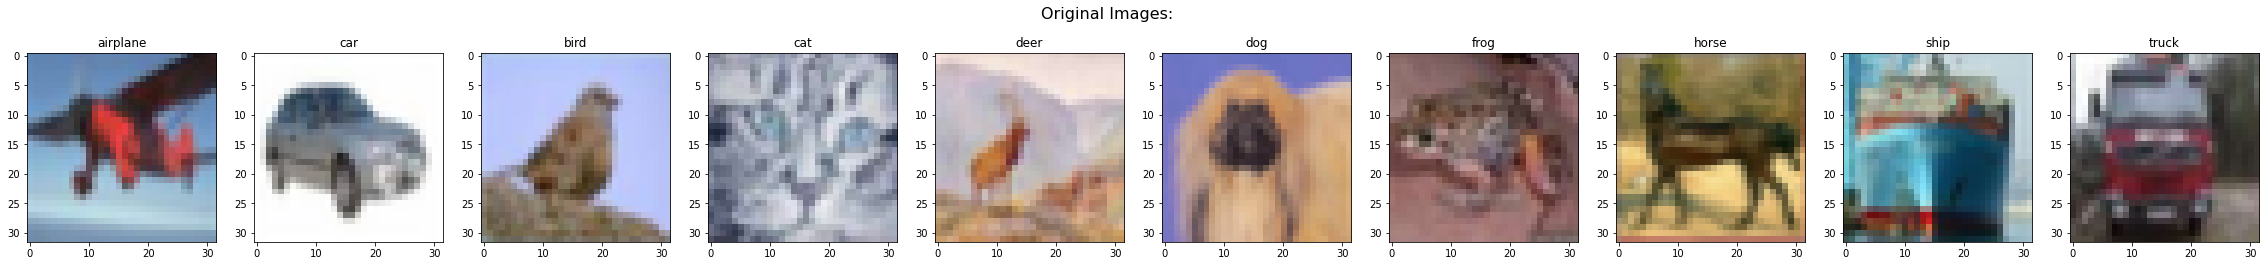

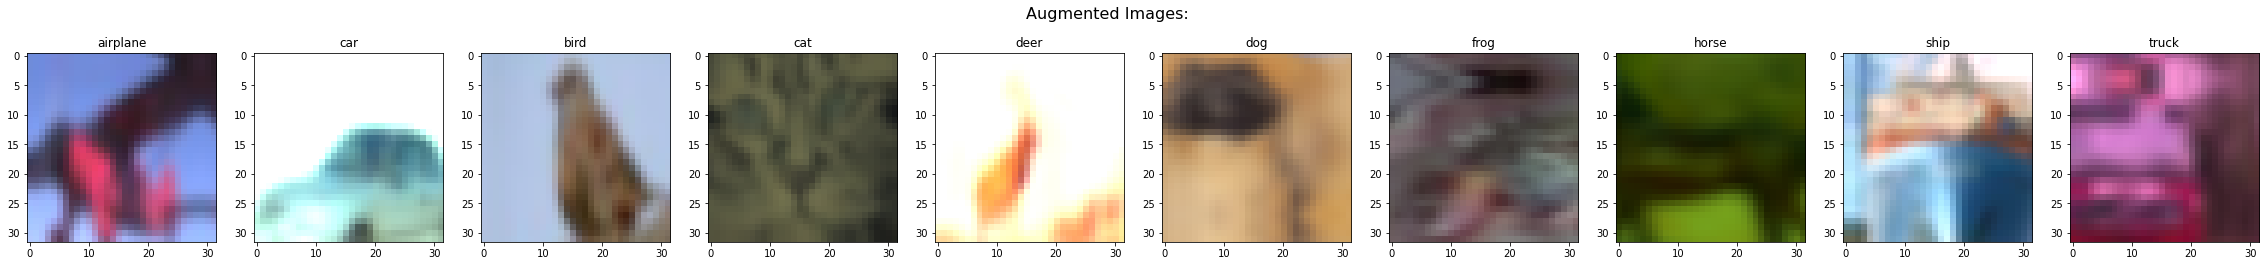

In [ ]:
# Dict of class labels to their actual displayed images
labels_to_classes = {0: 'airplane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# Get 1 image from each class
data = next(iter(uns_train_ds))
images = data[1]
images = images.numpy()
temp = {i: (images == i).nonzero()[0][0] for i in np.unique(images)}
temp.values()
images = [data[0][i] for i in temp.values()]
images = tf.stack(images, axis=0)

# Display the original images
plt.figure(figsize=(40, 20))
for i in range(len(images)):
  plt.subplot(1, len(images), i+1)
  plt.title(labels_to_classes[i])
  plt.imshow(images[i])
plt.suptitle('Original Images:', fontsize=16, y=0.6)

# Display the augmented images
aug_images = get_augmenter()(images)
plt.figure(figsize=(40, 20))
for i in range(len(images)):
  plt.subplot(1, len(images), i+1)
  plt.title(labels_to_classes[i])
  plt.imshow(aug_images[i])
plt.suptitle('Augmented Images:', fontsize=16, y=0.6)

In [ ]:
# Projection head used in SimCLR
def get_projection():
  # Non-linear layer with an additional hidden layer as outlined in paper
  inputs = layers.Input(shape=(256,))
  x = layers.Dense(256, activation="relu")(inputs)
  outputs = layers.Dense(256)(x)

  return tf.keras.Model(inputs, outputs, name="projection_head")

In [ ]:
!wget https://gist.githubusercontent.com/sayakpaul/0d2d367a9f9e2dd0941e2779c553c314/raw/609f10c2c5fade182191c8b2042c4da9348523d7/resnet_cifar10_v2.py resnet_cifar10_v2.py

--2022-11-21 12:32:01--  https://gist.githubusercontent.com/sayakpaul/0d2d367a9f9e2dd0941e2779c553c314/raw/609f10c2c5fade182191c8b2042c4da9348523d7/resnet_cifar10_v2.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6800 (6.6K) [text/plain]
Saving to: ‘resnet_cifar10_v2.py’

resnet_cifar10_v2.p 100%[===================>]   6.64K  --.-KB/s    in 0s      

2022-11-21 12:32:02 (55.3 MB/s) - ‘resnet_cifar10_v2.py’ saved [6800/6800]

--2022-11-21 12:32:02--  http://resnet_cifar10_v2.py/
Resolving resnet_cifar10_v2.py (resnet_cifar10_v2.py)... failed: Name or service not known.
wget: unable to resolve host address ‘resnet_cifar10_v2.py’
FINISHED --2022-11-21 12:32:02--
Total wall clock time: 0.3s
Downloaded: 1 files, 6.6K in 0s (55.3 MB/s)


In [ ]:
import resnet_cifar10_v2

resnet_blocks = 1

# Base encoder used in SimCLR and the Supervised learning's backbone structure
def get_encoder():
  # Adjustable # of identity blocks
  inputs = layers.Input((32, 32, 3))
  x = resnet_cifar10_v2.stem(inputs)
  x = resnet_cifar10_v2.learner(x, resnet_blocks)
  outputs = layers.GlobalAveragePooling2D()(x)

  return tf.keras.Model(inputs, outputs, name="base_encoder")

In [ ]:
# Supervised model for comparison to the semi-supervised model using SimCLR
inputs = keras.Input(shape=(32, 32, 3))
x = get_encoder()(inputs)
outputs = layers.Dense(10)(x)
supervised_model = tf.keras.Model(inputs, outputs, name="supervised")

callbacks = [keras.callbacks.ModelCheckpoint(filepath='supervised.keras', save_best_only=True, monitor='val_loss'),
             keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)]

supervised_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00002), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy()])

supervised_history = supervised_model.fit(sup_train_ds, epochs=100, validation_data=sup_val_ds, callbacks=callbacks)

Epoch 1/10
100/100 [==============================] - 21s 54ms/step - loss: 3.9076 - sparse_categorical_accuracy: 0.1300 - val_loss: 3.8229 - val_sparse_categorical_accuracy: 0.1080
Epoch 2/10
100/100 [==============================] - 8s 64ms/step - loss: 3.6436 - sparse_categorical_accuracy: 0.2105 - val_loss: 3.6478 - val_sparse_categorical_accuracy: 0.1860
Epoch 3/10
100/100 [==============================] - 8s 63ms/step - loss: 3.5478 - sparse_categorical_accuracy: 0.2580 - val_loss: 3.5063 - val_sparse_categorical_accuracy: 0.3060
Epoch 4/10
100/100 [==============================] - 8s 63ms/step - loss: 3.4727 - sparse_categorical_accuracy: 0.2755 - val_loss: 3.4122 - val_sparse_categorical_accuracy: 0.3420
Epoch 5/10
100/100 [==============================] - 7s 52ms/step - loss: 3.4194 - sparse_categorical_accuracy: 0.2805 - val_loss: 3.3435 - val_sparse_categorical_accuracy: 0.3540
Epoch 6/10
100/100 [==============================] - 5s 35ms/step - loss: 3.3587 - sparse_cat

In [ ]:
supervised_results = supervised_model.evaluate(test_ds)
print('Supervised accuracy on hold-out test set: {}'.format(supervised_results[1]))

100/100 [==============================] - 4s 30ms/step - loss: 3.1926 - sparse_categorical_accuracy: 0.3424
Supervised accuracy: 0.3424000144004822


In [ ]:
# Create the SimCLR architecture
class SimCLR(keras.Model):
  def __init__(self):
    super().__init__()
    self.tau = 0.1
    self.projection = get_projection()
    self.encoder = get_encoder()
    self.augmenter = get_augmenter()
    
  @property
  def metrics(self):
    return [self.loss_tracker, self.ssl_accuracy]

  def compile(self, optimizer):
    super().compile()
    self.optimizer = optimizer
    self.loss_tracker = keras.metrics.Mean(name="ssl_loss")
    self.ssl_accuracy = keras.metrics.SparseCategoricalAccuracy(name="ssl_accuracy")

  def max_agreement(self, z_i, z_j):
    # Find their cosine similarity
    norm_z_i = tf.math.l2_normalize(z_i, axis=1)
    norm_z_j = tf.math.l2_normalize(z_j, axis=1)
    cos_sim = (tf.matmul(norm_z_i, norm_z_j, transpose_b=True) / self.tau)
    # Find the number of parent image classes used in a batch
    batch_size = tf.shape(norm_z_i)[0]
    parent_classes = tf.range(batch_size)
    self.ssl_accuracy.update_state(parent_classes, cos_sim)
    self.ssl_accuracy.update_state(parent_classes, tf.transpose(cos_sim))
    # Make use of XEnt function using the Normalized Temperatures
    loss_1 = keras.losses.sparse_categorical_crossentropy(parent_classes, cos_sim, from_logits=True)
    loss_2 = keras.losses.sparse_categorical_crossentropy(parent_classes, tf.transpose(cos_sim), from_logits=True)
    # Return the found NT-XEnt
    return (loss_1 + loss_2) / 2


  def train_step(self, dataset):
    # Augment image twice to create two paths
    images, _ = dataset
    x_i = self.augmenter(images)
    x_j = self.augmenter(images)
    # Setup gradients for training 
    with tf.GradientTape() as g:
      # Run augmented images through base encoder
      h_i = self.encoder(x_i, training=True)
      h_j = self.encoder(x_j, training=True)
      # Then run through projection head
      z_i = self.projection(h_i, training=True)
      z_j = self.projection(h_j, training=True)
      # Maximize their agreement
      loss = self.max_agreement(z_i, z_j)
    # Update gradients and loss
    gradients = g.gradient(loss, self.encoder.trainable_weights + self.projection.trainable_weights)
    self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_weights + self.projection.trainable_weights))
    self.loss_tracker.update_state(loss)

    return {m.name: m.result() for m in self.metrics}

callbacks = [keras.callbacks.ModelCheckpoint(filepath='simclr.keras', save_weights_only=True, save_best_only=True, monitor='ssl_loss'),
             keras.callbacks.EarlyStopping(monitor='ssl_loss', patience=8)]

simclr_model = SimCLR()
simclr_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
simclr_history = simclr_model.fit(uns_train_ds, epochs=100, callbacks=callbacks)

Epoch 1/10
100/100 [==============================] - 21s 162ms/step - ssl_loss: 3.0730 - ssl_accuracy: 0.4223
Epoch 2/10
100/100 [==============================] - 18s 166ms/step - ssl_loss: 1.0403 - ssl_accuracy: 0.8401
Epoch 3/10
100/100 [==============================] - 20s 175ms/step - ssl_loss: 0.6102 - ssl_accuracy: 0.9400
Epoch 4/10
100/100 [==============================] - 18s 166ms/step - ssl_loss: 0.4222 - ssl_accuracy: 0.9697
Epoch 5/10
100/100 [==============================] - 18s 164ms/step - ssl_loss: 0.3208 - ssl_accuracy: 0.9817
Epoch 6/10
100/100 [==============================] - 18s 166ms/step - ssl_loss: 0.2528 - ssl_accuracy: 0.9892
Epoch 7/10
100/100 [==============================] - 18s 164ms/step - ssl_loss: 0.2165 - ssl_accuracy: 0.9912
Epoch 8/10
100/100 [==============================] - 18s 169ms/step - ssl_loss: 0.1832 - ssl_accuracy: 0.9934
Epoch 9/10
100/100 [==============================] - 19s 171ms/step - ssl_loss: 0.1615 - ssl_accuracy: 0.9956
E

In [ ]:
# Perform Semi-Supervised learning with the learned representations from SimCLR
inputs = layers.Input((32, 32, 3))
x = simclr_model.encoder(inputs)
outputs = layers.Dense(10)(x)
semi_supervised_model = tf.keras.Model(inputs, outputs, name="semi_supervised_model")

callbacks = [keras.callbacks.ModelCheckpoint(filepath='semi_supervised.keras', save_best_only=True, monitor='val_loss'),
             keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)]

semi_supervised_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00002), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy()])

semi_supervised_history = semi_supervised_model.fit(sup_train_ds, epochs=100, validation_data=sup_val_ds, callbacks=callbacks)

Epoch 1/10
100/100 [==============================] - 9s 41ms/step - loss: 3.7859 - sparse_categorical_accuracy: 0.1520 - val_loss: 3.7703 - val_sparse_categorical_accuracy: 0.1440
Epoch 2/10
100/100 [==============================] - 4s 34ms/step - loss: 3.6333 - sparse_categorical_accuracy: 0.2130 - val_loss: 3.6172 - val_sparse_categorical_accuracy: 0.2120
Epoch 3/10
100/100 [==============================] - 5s 35ms/step - loss: 3.5382 - sparse_categorical_accuracy: 0.2565 - val_loss: 3.5070 - val_sparse_categorical_accuracy: 0.2880
Epoch 4/10
100/100 [==============================] - 6s 50ms/step - loss: 3.4600 - sparse_categorical_accuracy: 0.2885 - val_loss: 3.4139 - val_sparse_categorical_accuracy: 0.3140
Epoch 5/10
100/100 [==============================] - 5s 35ms/step - loss: 3.3980 - sparse_categorical_accuracy: 0.3095 - val_loss: 3.3408 - val_sparse_categorical_accuracy: 0.3180
Epoch 6/10
100/100 [==============================] - 5s 36ms/step - loss: 3.3314 - sparse_cate

In [ ]:
semi_supervised_results = semi_supervised_model.evaluate(test_ds)
print('Semi-Supervised accuracy on hold-out test set: {}'.format(semi_supervised_results[1]))

100/100 [==============================] - 1s 14ms/step - loss: 3.1284 - sparse_categorical_accuracy: 0.3599
Semi-Supervised accuracy on hold-out test set: 0.35989999771118164


Text(0, 0.5, 'Validation Accuracy')

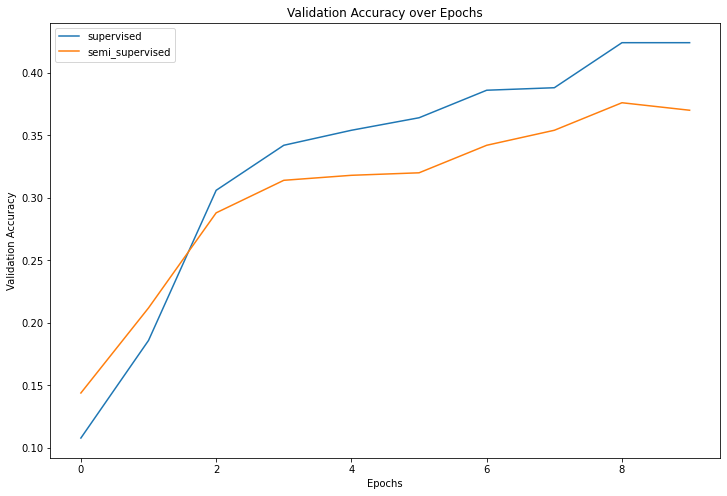

In [ ]:
# Compare Accuracy
plt.figure(figsize=(12, 8))
plt.plot(supervised_history.history['val_sparse_categorical_accuracy'])
plt.plot(semi_supervised_history.history['val_sparse_categorical_accuracy'])
plt.legend(['supervised', 'semi_supervised'])
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

Text(0, 0.5, 'Validation Loss')

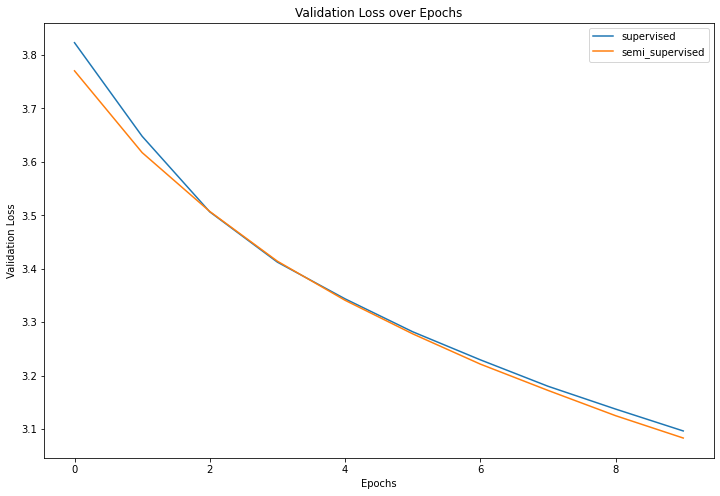

In [ ]:
# Compare Loss
plt.figure(figsize=(12, 8))
plt.plot(supervised_history.history['val_loss'])
plt.plot(semi_supervised_history.history['val_loss'])
plt.legend(['supervised', 'semi_supervised'])
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')